In [2]:
# Importing Dependencies
import numpy as np
from typing import List, Dict, Tuple, Union
from numpy.typing import ArrayLike

In [589]:
class NeuralNetwork:
    """
    This is a neural network class that generates a fully connected Neural Network.

    Parameters:
        nn_arch: List[Dict[str, float]]
            This list of dictionaries describes the fully connected layers of the artificial neural network.
            e.g. [{'input_dim': 64, 'output_dim': 32, 'activation': 'relu'}, {'input_dim': 32, 'output_dim': 8, 'activation:': 'sigmoid'}] will generate a
            2 layer deep fully connected network with an input dimension of 64, a 32 dimension hidden layer
            and an 8 dimensional output.
        lr: float
            Learning Rate (alpha).
        seed: int
            Random seed to ensure reproducibility.
        batch_size: int
            Size of mini-batches used for training.
        epochs: int
            Max number of epochs for training.
        loss_function: str
            Name of loss function.

    Attributes:
        arch: list of dicts
            This list of dictionaries describing the fully connected layers of the artificial neural network.
    """
    def __init__(self,
                 nn_arch: List[Dict[str, Union[int, str]]],
                 lr: float,
                 seed: int,
                 batch_size: int,
                 epochs: int,
                 loss_function: str):
        # Saving architecture
        self.arch = nn_arch
        # Saving hyperparameters
        self._lr = lr
        self._seed = seed
        self._epochs = epochs
        self._loss_func = loss_function
        self._batch_size = batch_size
        # Initializing the parameter dictionary for use in training
        self._param_dict = self._init_params()

    def _init_params(self) -> Dict[str, ArrayLike]:
        """
        DO NOT MODIFY THIS METHOD!! IT IS ALREADY COMPLETE!!

        This method generates the parameter matrices for all layers of
        the neural network. This function returns the param_dict after
        initialization.

        Returns:
            param_dict: Dict[str, ArrayLike]
                Dictionary of parameters in neural network.
        """
        # seeding numpy random
        np.random.seed(self._seed)
        # defining parameter dictionary
        param_dict = {}
        # initializing all layers in the NN
        for idx, layer in enumerate(self.arch):
            layer_idx = idx + 1
            input_dim = layer['input_dim']
            output_dim = layer['output_dim']
            # initializing weight matrices
            param_dict['W' + str(layer_idx)] = np.random.randn(output_dim, input_dim) * 0.1
            # initializing bias matrices
            param_dict['b' + str(layer_idx)] = np.random.randn(output_dim, 1) * 0.1
        return param_dict

    def _single_forward(self,
                        W_curr: ArrayLike,
                        b_curr: ArrayLike,
                        A_prev: ArrayLike,
                        activation: str) -> Tuple[ArrayLike, ArrayLike]:
        """
        This method is used for a single forward pass on a single layer.

        Args:
            W_curr: ArrayLike
                Current layer weight matrix.
            b_curr: ArrayLike
                Current layer bias matrix.
            A_prev: ArrayLike
                Previous layer activation matrix.
            activation: str
                Name of activation function for current layer.

        Returns:
            A_curr: ArrayLike
                Current layer activation matrix.
            Z_curr: ArrayLike
                Current layer linear transformed matrix.
        """
        Z_curr = np.transpose(np.matmul(W_curr, np.transpose(A_prev)))
        #print(f'_single_forward: b_curr is {b_curr.shape}')
        Z_curr = Z_curr + b_curr.flatten()
        if activation == "sigmoid":
            A_curr = self._sigmoid(Z_curr) 
        elif activation == "relu":
            A_curr = self._relu(Z_curr)
        return A_curr, Z_curr

    def forward(self, X: ArrayLike) -> Tuple[ArrayLike, Dict[str, ArrayLike]]:
        """
        This method is responsible for one forward pass of the entire neural network.

        Args:
            X: ArrayLike
                Input matrix with shape [batch_size, features].

        Returns:
            output: ArrayLike
                Output of forward pass.
            cache: Dict[str, ArrayLike]:
                Dictionary storing Z and A matrices from `_single_forward` for use in backprop.
        """
        A_prev = X
        cache = {'0': (A_prev,)}
        for idx, layer in enumerate(self.arch):
            W_curr = self._param_dict['W' + str(idx + 1)]
            b_curr = self._param_dict['b' + str(idx + 1)]
            #print(f'forward: layer is {layer}')
            #print(f'forward: b_curr is {b_curr.shape}')
            activation = layer["activation"]
            A_prev = cache[str(idx)][0]
            cache[str(idx + 1)] = self._single_forward(W_curr, b_curr, A_prev, activation)
        n_layers = len(self.arch)
        output = cache[str(n_layers)][0]
        return output, cache

    def _single_backprop(self,
                         W_curr: ArrayLike,
                         b_curr: ArrayLike,
                         Z_curr: ArrayLike,
                         A_prev: ArrayLike,
                         dA_curr: ArrayLike,
                         activation_curr: str) -> Tuple[ArrayLike, ArrayLike, ArrayLike]:
        """
        This method is used for a single backprop pass on a single layer.

        Args:
            W_curr: ArrayLike
                Current layer weight matrix.
            b_curr: ArrayLike
                Current layer bias matrix.
            Z_curr: ArrayLike
                Current layer linear transform matrix.
            A_prev: ArrayLike
                Previous layer activation matrix.
            dA_curr: ArrayLike
                Partial derivative of loss function with respect to current layer activation matrix.
            activation_curr: str
                Name of activation function of layer.

        Returns:
            dA_prev: ArrayLike
                Partial derivative of loss function with respect to previous layer activation matrix.
            dW_curr: ArrayLike
                Partial derivative of loss function with respect to current layer weight matrix.
            db_curr: ArrayLike
                Partial derivative of loss function with respect to current layer bias matrix.
        """
        
        # calculate the partial derivative of the current activation matrix
        # with respect to the current linear output matrix ("Z")
        
        if activation_curr == "relu":
            dJ_dZcurr = self._relu_backprop(dA_curr, Z_curr)
        elif activation_curr == "sigmoid":
            dJ_dZcurr = self._sigmoid_backprop(dA_curr, Z_curr)
        
        # calculate the partial derivate of the loss function with
        # respect to the previous activation layer, dJ_dAprev 
        dZcurr_dAprev = W_curr
        dJ_dAprev = np.array([np.matmul(dJ_dZcurr[i,:], dZcurr_dAprev) for i in range(dJ_dZcurr.shape[0])])
        
        # calculate the partial derivate of the loss function with
        # respect to the bias of the current layer, dJ_dbcurr 
        dJ_dbcurr = np.sum(dJ_dZcurr, axis = 0) # (64,)
        #print(f'_single_backprop: dJ_dbcurr is {dJ_dbcurr.shape}')
        
        # calculate the partial derivative of the loss function with
        # respect to the weights of the current layer, dJ_dWcurr 
        dZcurr_dWcurr = np.tile(A_prev , (W_curr.shape[0], 1, 1)) # (64, 10, 16)
        dJ_dZcurr = np.tile(dJ_dZcurr, (W_curr.shape[1], 1, 1)) # (16, 10, 64)
        dJ_dZcurr = np.moveaxis(dJ_dZcurr, [2,0],[0,2]) # (64, 10, 16)
        dJ_dWcurr = np.sum(dJ_dZcurr * dZcurr_dWcurr, axis = 1) # (64, 16)
        
        return dJ_dWcurr, dJ_dbcurr, dJ_dAprev
        
                
    def backprop(self, y: ArrayLike, y_hat: ArrayLike, cache: Dict[str, ArrayLike]):
        """
        This method is responsible for the backprop of the whole fully connected neural network.

        Args:
            y (array-like):
                Ground truth labels.
            y_hat: ArrayLike
                Predicted output values.
            cache: Dict[str, ArrayLike]
                Dictionary containing the information about the
                most recent forward pass, specifically A and Z matrices.

        Returns:
            grad_dict: Dict[str, ArrayLike]
                Dictionary containing the gradient information from this pass of backprop.
        """
        n_layers = len(layers)
        grad_dict = dict()
        
        if self._loss_func == "BCE":
            dJ_dAcurr = self._binary_cross_entropy_backprop(y, y_hat)
        elif self._loss_func == "MSE":
            dJ_dAcurr = self._mean_squared_error_backprop(y, y_hat)
        
        for idx, layer in enumerate(reversed(layers)):
            W_curr = self._param_dict["W" + str(n_layers - idx)]
            b_curr = self._param_dict["b" + str(n_layers - idx)]
            Z_curr = cache[str(n_layers - idx)][1]
            A_prev = cache[str(n_layers - idx - 1)][0]    
            dA_curr = dJ_dAcurr
            activation_curr = layer["activation"]
            dJ_dWcurr, dJ_dbcurr, dJ_dAprev = self._single_backprop(W_curr, b_curr, Z_curr, 
                                                               A_prev, dA_curr, activation_curr)
            grad_dict["W" + str(n_layers - idx)] = dJ_dWcurr
            grad_dict["b" + str(n_layers - idx)] = dJ_dbcurr
            dJ_dAcurr = dJ_dAprev
            
        return grad_dict

    def _update_params(self, grad_dict: Dict[str, ArrayLike]):
        """
        This function updates the parameters in the neural network after backprop. This function
        only modifies internal attributes and thus does not return anything

        Args:
            grad_dict: Dict[str, ArrayLike]
                Dictionary containing the gradient information from most recent round of backprop.

        Returns:
            None
        """
        for idx in range(1, len(self.arch) + 1):
            self._param_dict["W" + str(idx)] = self._param_dict["W" + str(idx)] - self._lr * grad_dict["W" + str(idx)]
            self._param_dict["b" + str(idx)] = self._param_dict["b" + str(idx)].flatten() - self._lr * grad_dict["b" + str(idx)]
            
    def fit(self,
            X_train: ArrayLike,
            y_train: ArrayLike,
            X_val: ArrayLike,
            y_val: ArrayLike) -> Tuple[List[float], List[float]]:
        """
        This function trains the neural network via training for the number of epochs defined at
        the initialization of this class instance.
        Args:
            X_train: ArrayLike
                Input features of training set.
            y_train: ArrayLike
                Labels for training set.
            X_val: ArrayLike
                Input features of validation set.
            y_val: ArrayLike
                Labels for validation set.

        Returns:
            per_epoch_loss_train: List[float]
                List of per epoch loss for training set.
            per_epoch_loss_val: List[float]
                List of per epoch loss for validation set.
        """
        per_epoch_loss_train = []
        per_epoch_loss_val = []
        for t in range(self._epochs):
            this_epoch_loss_train = []
            n_batches = np.ceil(len(y_train)/self._batch_size)
            shuffler = np.random.permutation(X_train.shape[0])
            X_train = X_train[shuffler,:]
            y_train = y_train[shuffler]
            count = 0
            # train the network in batches
            for X_train_batch, y_train_batch in zip(np.array_split(X_train, n_batches), np.array_split(y_train, n_batches)):
                output, cache = self.forward(X_train_batch)
                if self._loss_func == "BCE":
                    this_epoch_loss_train.append(self._binary_cross_entropy(y_train_batch, output))
                elif self._loss_func == "MSE":
                    this_epoch_loss_train.append(self._mean_squared_error(y_train_batch, output))
                grad_dict = self.backprop(y_train_batch, output, cache)
                self._update_params(grad_dict)
                count += 1
            per_epoch_loss_train.append(np.mean(this_epoch_loss_train))
            
            # compute validation loss
            output, _ = self.forward(X_val)
            if self._loss_func == "BCE":
                per_epoch_loss_val.append(self._binary_cross_entropy(y_val, output))
            elif self._loss_func == "MSE":
                per_epoch_loss_val.append(self._mean_squared_error(y_val, output))
            
                
            
        return per_epoch_loss_train, per_epoch_loss_val
                

    def predict(self, X: ArrayLike) -> ArrayLike:
        """
        This function returns the prediction of the neural network model.

        Args:
            X: ArrayLike
                Input data for prediction.

        Returns:
            y_hat: ArrayLike
                Prediction from the model.
        """
        output, _ = self.forward(X)
        return output

    def _sigmoid(self, Z: ArrayLike) -> ArrayLike:
        """
        Sigmoid activation function.

        Args:
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            nl_transform: ArrayLike
                Activation function output.
        """
        return 1/(1 + np.exp(-Z))

    def _relu(self, Z: ArrayLike) -> ArrayLike:
        """
        ReLU activation function.

        Args:
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            nl_transform: ArrayLike
                Activation function output.
        """
        Z[Z < 0] = 0
        return Z

    def _sigmoid_backprop(self, dA: ArrayLike, Z: ArrayLike):
        """
        Sigmoid derivative for backprop.

        Args:
            dA: ArrayLike
                Partial derivative of previous layer activation matrix.
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            dJ_dZcurr: ArrayLike
                Partial derivative of current layer Z matrix.
        """
        dAcurr_dZcurr = self._sigmoid(Z) * (1 - self._sigmoid(Z))
        dJ_dZcurr = dA * dAcurr_dZcurr
        
        return dJ_dZcurr

    def _relu_backprop(self, dA: ArrayLike, Z: ArrayLike) -> ArrayLike:
        """
        ReLU derivative for backprop.

        Args:
            dA: ArrayLike
                Partial derivative of previous layer activation matrix.
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            dJ_dZcurr: ArrayLike
                Partial derivative of current layer Z matrix.
        """
        dAcurr_dZcurr = Z
        dAcurr_dZcurr[Z >= 0] = 1
        dAcurr_dZcurr[Z < 0] = 0
        dJ_dZcurr = dA * dAcurr_dZcurr
        
        return dJ_dZcurr
        

    def _binary_cross_entropy(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        """
        Binary cross entropy loss function.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            loss: float
                Average loss over mini-batch.
        """
        y_hat[y_hat == 0] = 0.0001
        y_hat[y_hat == 1] = 0.9999
        term1 = y * np.log(y_hat)
        term2 = (1 - y) * np.log(1 - y_hat)
        return -np.mean(term1 + term2)

    def _binary_cross_entropy_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        """
        Binary cross entropy loss function derivative.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            dA: ArrayLike
                partial derivative of loss with respect to A matrix.
        """
        y_hat[y_hat == 0] = 0.0001
        y_hat[y_hat == 1] = 0.9999
        num = y_hat - y
        den = y_hat * (1 - y_hat)
        dJ_dAcurr = num/den
        
        return dJ_dAcurr

    def _mean_squared_error(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        """
        Mean squared error loss.

        Args:
            y: ArrayLike
                Ground truth output.
            y_hat: ArrayLike
                Predicted output.

        Returns:
            loss: float
                Average loss of mini-batch.
        """
        return np.mean(np.square(y - y_hat))

    def _mean_squared_error_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        """
        Mean square error loss derivative.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            dA: ArrayLike
                partial derivative of loss with respect to A matrix.
        """
        return -2 * (y - y_hat) / y.shape[0]

    def _loss_function(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        """
        Loss function, computes loss given y_hat and y. This function is
        here for the case where someone would want to write more loss
        functions than just binary cross entropy.

        Args:
            y: ArrayLike
                Ground truth output.
            y_hat: ArrayLike
                Predicted output.
        Returns:
            loss: float
                Average loss of mini-batch.
        """
        pass

    def _loss_function_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        """
        This function performs the derivative of the loss function with respect
        to the loss itself.
        Args:
            y (array-like): Ground truth output.
            y_hat (array-like): Predicted output.
        Returns:
            dA (array-like): partial derivative of loss with respect
                to A matrix.
        """
        pass

In [590]:
layers = [{'input_dim': 64, 'output_dim': 16, 'activation': 'sigmoid'}, 
          {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'}]

In [591]:
nn = NeuralNetwork(layers, lr = 0.05, seed = 0, batch_size = 100, epochs = 10, loss_function = "MSE")

In [587]:
train_loss, val_loss = nn.fit(X_train, X_train, X_test, X_test)

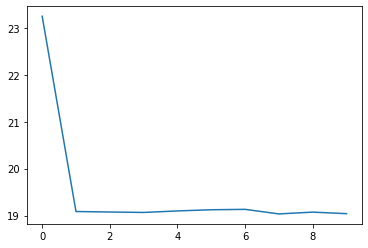

In [588]:
plt.plot(range(10), train_loss)

In [574]:
out, _ = nn.forward(X_train)

<Figure size 432x288 with 0 Axes>

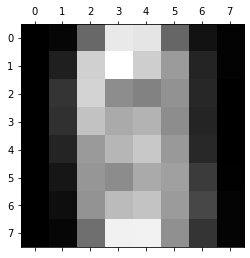

In [575]:
plt.gray()
plt.matshow(out[0].reshape((8,8)))

<Figure size 432x288 with 0 Axes>

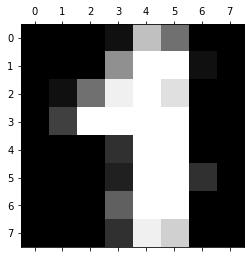

In [576]:
plt.gray()
plt.matshow(X_train[0].reshape((8,8)))

In [116]:
from sklearn.datasets import load_digits
digits = load_digits()

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
X = digits['data']
y = digits['target']

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [129]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

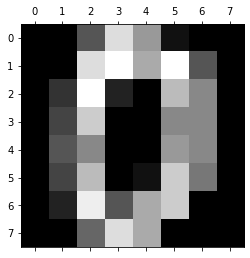

In [132]:
plt.gray()
plt.matshow(digits.images[0])

In [72]:
y = np.array([[0.]])
y_hat = np.array([[0.5]])

In [67]:
y_hat

array([[0.5]])

In [68]:
y_hat[y_hat == 0] = 0.0001
y_hat[y_hat == 1] = 0.9999
term1 = y * np.log(y_hat)
#print(f'_binary_cross_entropy: term1 shape is {term1.shape}')
term2 = (1 - y) * np.log(1 - y_hat)
#print(f'_binary_cross_entropy: term2 shape is {term2.shape}')
bce = -np.mean(term1 + term2)


In [69]:
bce

0.6931471805599453

In [63]:
term1

array([[-0.69314718]])

In [64]:
term2

array([[-0.]])

In [73]:
num = y_hat - y
den = y_hat * (1 - y_hat)

In [74]:
num/den

array([[2.]])